# Evaluación RAG

## Carga de Documentos y Datos de Referencia

Para evaluar el sistema RAG de forma offline, se necesita contar con dos conjuntos de datos:  

1. **Documentos con identificadores únicos** que simulan la base de conocimiento.
2. **Datos de referencia (ground truth)** que contienen preguntas, respuestas esperadas e identificadores de los documentos relevantes.

Este fragmento de código carga ambos conjuntos desde archivos remotos hospedados en GitHub:

In [1]:
import requests
import pandas as pd

In [2]:
url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

In [3]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [4]:
ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [5]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

Para facilitar la recuperación de documentos individuales, se construye un **índice en forma de diccionario** donde cada clave es el ID de un documento y su valor es el contenido completo del mismo:

In [6]:
doc_idx = {d['id']: d for d in documents}

In [7]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [8]:
doc_idx['ea739c65']['text']

'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.'

## Indexar datos

Vamos a generar *embeddings* utilizando la librería [sentence transformers](https://sbert.net/). Si no la tienes instalada, puedes hacerlo con el siguiente comando:

```bash
pip install sentence-transformers
```

Esta es una forma diferente de convertir oraciones en vectores.

In [9]:
import numpy as np

from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from minsearch import VectorSearch

In [10]:
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

Generación de vectores a partir de preguntas y documentos

Este fragmento recorre todos los documentos y genera un vector para cada uno utilizando el modelo *multi-qa-MiniLM-L6-cos-v1* de *sentence transformers*. Para cada documento, concatena la pregunta (`question`) con el texto (`text`) y luego genera un vector de representación (embedding).

In [11]:
vectors = []

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    vector = model.encode(question + ' ' + text)
    vectors.append(vector)

  0%|          | 0/948 [00:00<?, ?it/s]

/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [12]:
vectors = np.array(vectors)


Una vez generados los vectores que representan cada documento, es necesario construir un índice que permita realizar búsquedas eficientes sobre ellos. Para eso, se utiliza la clase `VectorSearch`.


In [13]:
vindex = VectorSearch(keyword_fields=['course'])
vindex.fit(vectors, documents)

## Recuperación

Estas funciones permiten realizar una **búsqueda semántica personalizada** basada en una pregunta y el curso al que pertenece. Utilizan el índice vectorial previamente creado para encontrar los documentos más relevantes.

In [14]:
def minsearch_vector_search(vector, course):
    return vindex.search(
        vector,
        filter_dict={'course': course},
        num_results=5
    )

def question_text_vector(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return minsearch_vector_search(v_q, course)

In [15]:
question_text_vector(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'section': 'General course-related questions',
  'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'id': '5170565b'},
 {'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'section': 'General course-related questions',
  'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'id': '39fda9f0'},
 {'text': "Problem description\nThe accuracy and the loss are both still the same or nearly the same while training.\nSol

## El flujo RAG

Esta función genera un **prompt estructurado** que se enviará al modelo de lenguaje (LLM). El objetivo es formular una solicitud que le indique al modelo cómo responder usando únicamente información relevante proveniente de documentos previamente recuperados.

In [16]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

Este código define una función que utiliza la API de OpenAI para enviar un **prompt** a un modelo de lenguaje (LLM) y obtener una respuesta generada.

In [17]:
import os
from dotenv import load_dotenv

load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")

if openai_key is None:
    print("La variable OPENAI_API_KEY no está definida en el archivo .env")
else:
    print("La variable OPENAI_API_KEY está definida correctamente.")

La variable OPENAI_API_KEY está definida correctamente.


In [18]:
from openai import OpenAI

client = OpenAI()

def llm(prompt, model='gpt-4o-mini'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

Esta función implementa el flujo completo de un sistema **RAG (Retrieval-Augmented Generation)**: primero recupera documentos relevantes y luego genera una respuesta usando un modelo LLM.

In [19]:
def rag(query: dict, model='gpt-4o-mini') -> str:
    search_results = question_text_vector(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [20]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [21]:
rag(ground_truth[10])

/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


'Yes, sessions are recorded, so if you miss one, you won’t miss anything. You can also submit your questions in advance for office hours, which will be covered during the live stream.'

In [22]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Métrica de similitud de coseno

Este fragmento de código compara dos respuestas —una original (ground truth) y una generada por el LLM— utilizando **vectores de embeddings** y el **producto punto** como medida de similitud.

In [36]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


np.float32(0.759117)

Este proceso recorre un conjunto de datos que contiene preguntas, documentos y metadatos asociados para evaluar el rendimiento de un sistema RAG (Retrieval-Augmented Generation). Los pasos principales son:

- **Verificación de respuestas previas**: Se omiten las preguntas para las cuales ya se tiene una respuesta registrada, facilitando la ejecución en múltiples etapas.
- **Generación de respuesta**: Se utiliza un sistema RAG para generar una respuesta a partir de la pregunta y su contexto relevante.
- **Recuperación del contenido original**: Se obtiene el texto original del documento vinculado a la pregunta, lo cual permite comparar la respuesta generada con la fuente original.
- **Registro de resultados**: Se guarda un objeto con la respuesta del modelo, la respuesta original, el identificador del documento, la pregunta y el nombre del curso. Esto forma un dataset útil para evaluación posterior.

Este mecanismo permite construir una base de datos evaluable para comparar y analizar las respuestas generadas frente a sus fuentes originales, y sirve como base para aplicar métricas de evaluación semántica o de relevancia.


In [37]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [38]:
len(ground_truth)

1830

In [41]:
answers = {}

In [42]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

  0%|          | 0/1830 [00:00<?, ?it/s]

/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modu

**Costo del procesamiento aproximadamente 0.22 $**

In [46]:
answers[0]

{'answer_llm': 'You can sign up for the course by visiting the course page at http://mlzoomcamp.com/.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

Si olvidaste registrar alguna entrada del *ground truth* en el diccionario de respuestas (`answers`), podés volver a ejecutar este bloque para completar las que faltan sin sobrescribir las ya existentes.

In [47]:
results_gpt4o_mini = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o_mini[i] = val.copy()
    results_gpt4o_mini[i].update(ground_truth[i])

Se crea un *DataFrame* de pandas a partir de los resultados obtenidos con el modelo `gpt-4o-mini` y luego se guarda en un archivo CSV llamado `results-gpt4o-mini.csv` dentro de la carpeta `data`, sin incluir el índice en el archivo.


In [48]:
import pandas as pd

df_gpt4o_mini = pd.DataFrame(results_gpt4o_mini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

## Evaluación del GPT 3.5 turbo

En vez de usar **gpt4o-mini** ahora usamos **gpt-3.5-turbo**

In [91]:
rag(ground_truth[10], model='gpt-3.5-turbo')

/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


"No, sessions are recorded so if you miss one, you won't miss anything."

Esta función procesa un registro de evaluación individual utilizando un modelo específico (por defecto, `gpt-3.5-turbo`). A partir de una pregunta, genera una respuesta con RAG, recupera la respuesta original del documento de referencia y devuelve un diccionario con toda la información necesaria para análisis o comparación posterior: respuesta generada, respuesta original, ID del documento, pregunta y curso correspondiente.

In [92]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [93]:
process_record(ground_truth[10])

/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'answer_llm': 'Yes, sessions are recorded so if you miss one, you can watch the recording later.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

Esta porción de código permite aplicar una función sobre una secuencia de elementos de forma paralela, mostrando el progreso en tiempo real.

1. **`ThreadPoolExecutor`**: Se crea un *pool* de 6 hilos para ejecutar tareas en paralelo.
2. **`map_progress`**: Esta función toma el *pool*, una secuencia de elementos (`seq`) y una función (`f`) que se aplicará a cada elemento.
3. Por cada elemento de la secuencia, se envía una tarea al *pool* para que se ejecute en un hilo separado.
4. A medida que cada tarea finaliza, se actualiza una barra de progreso visual gracias a `tqdm`.
5. Una vez que todas las tareas terminan, se recogen los resultados y se devuelven como una lista.

Este patrón es útil para acelerar tareas como el procesamiento de preguntas o documentos, especialmente cuando se trabaja con LLMs o funciones de recuperación costosas.


In [94]:
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=4)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [95]:
results_gpt41_nano = map_progress(pool, ground_truth, process_record)

  0%|          | 0/1830 [00:00<?, ?it/s]

/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modu

**Costo del procesamiento aproximadamente 1.88 $**

Se construye un DataFrame con los resultados generados por el modelo `gpt-3.5-turbo` y se exporta a un archivo CSV llamado `results-gpt-3.5-turbo.csv` dentro de la carpeta `data`, omitiendo el índice en el archivo.

In [96]:
df_gptresults_gpt35_turbo = pd.DataFrame(results_gpt41_nano)
df_gptresults_gpt35_turbo.to_csv('data/results-gpt-3.5-turbo.csv', index=False)

In [99]:
!head data/results-gpt-3.5-turbo.csv

answer_llm,answer_orig,document,question,course
You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"Sorry, I cannot provide a link to sign up.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Similitud del coseno

La **similitud del coseno** es una métrica utilizada para medir qué tan similares son dos vectores en un espacio multidimensional, independientemente de su magnitud.

En lugar de comparar los valores absolutos de los vectores, se enfoca en el **ángulo entre ellos**. Si el ángulo es pequeño (es decir, los vectores apuntan en la misma dirección), la similitud es alta.

A -> Q -> A'

cosine(A, A')

A = respuesta orginal 
Q = pregunta
A' = respuesta del LLM

### gpt-4o - similitud de coseno

In [13]:
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm

df_gpt4o = pd.read_csv('data/results-gpt4o.csv')
results_gpt4o = df_gpt4o.to_dict(orient="records")

In [5]:
record = results_gpt4o[0]
record

{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [7]:
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [8]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [10]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995338
Name: cosine, dtype: float64

/tmp/ipykernel_1857/2967343473.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

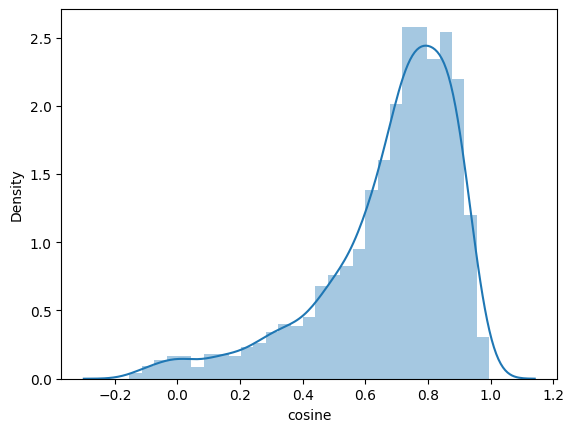

In [14]:
sns.distplot(df_gpt4o['cosine'])

### gpt-3.5-turbo - similitud de coseno

In [20]:
df_gpt35 = pd.read_csv('data/results-gpt-3.5-turbo.csv')
results_gpt35 = df_gpt35.to_dict(orient="records")

In [21]:
results_gpt35[0]

{'answer_llm': 'You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [23]:
similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [24]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.656349
std         0.223930
min        -0.156218
25%         0.550437
50%         0.712021
75%         0.815440
max         0.997980
Name: cosine, dtype: float64

/tmp/ipykernel_1857/1662309756.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

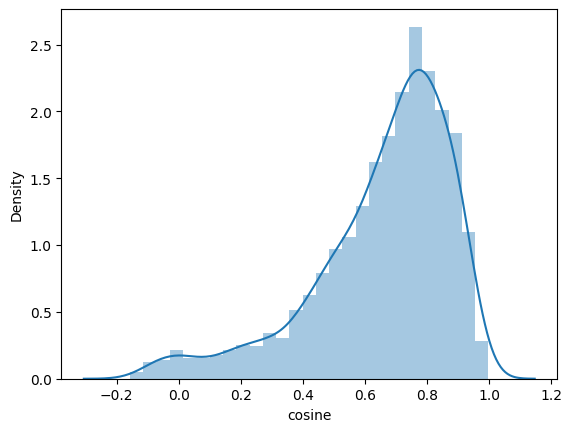

In [25]:
sns.distplot(df_gpt35['cosine'])

### gpt-4o-mini

Si desea crear su propio metodo para consumir `gpt-4o-mini` puede hacer esto:

```python
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

results_gpt4omini = []

for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)
```

In [25]:
df_gpt4o_mini = pd.read_csv('data/results-gpt4o-mini.csv')
results_gpt4o_mini = df_gpt4o_mini.to_dict(orient="records")

In [26]:
results_gpt4o_mini[0]

{'answer_llm': 'You can sign up for the course by visiting the course page at http://mlzoomcamp.com/.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [66]:
similarity_4o_mini = []

for record in tqdm(results_gpt4o_mini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

/home/joviedo/github-repos/llm-zoomcamp-knowledge-base/week3/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [67]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680058
std         0.215891
min        -0.140283
25%         0.591496
50%         0.735214
75%         0.835779
max         0.988077
Name: cosine, dtype: float64

/tmp/ipykernel_1857/3866689262.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

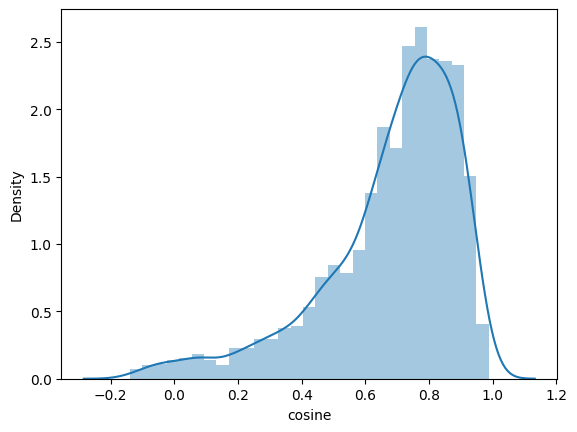

In [71]:
sns.distplot(df_gpt4o_mini['cosine'])

-------------------------------------

/tmp/ipykernel_1857/3167800536.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='3.5')
/tmp/ipykernel_1857/3167800536.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/tmp/ipykernel_1857/3167800536.py:5: UserWarning: 

`distplot` is

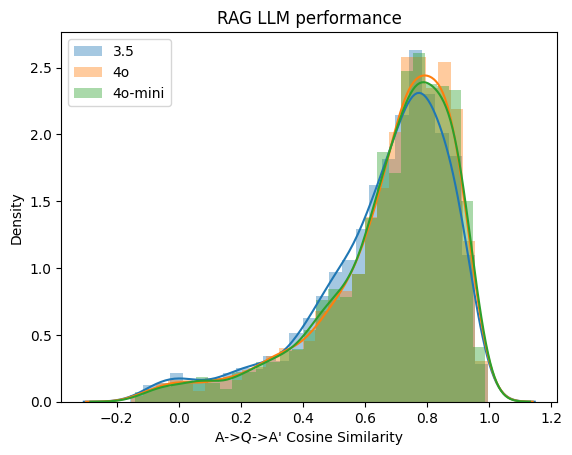

In [77]:
import matplotlib.pyplot as plt

sns.distplot(df_gpt35['cosine'], label='3.5')
sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

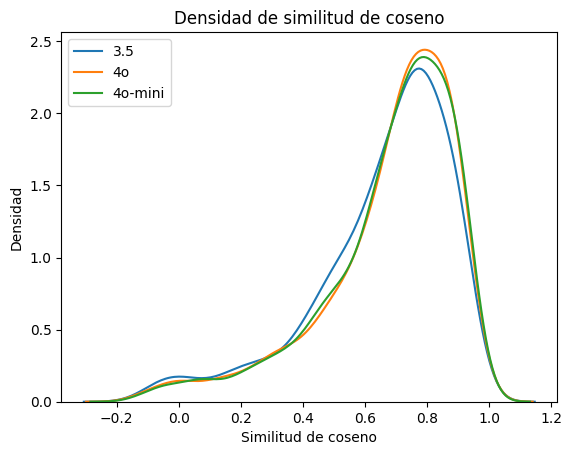

In [86]:
sns.kdeplot(data=df_gpt35, x='cosine', label='3.5')
sns.kdeplot(data=df_gpt4o, x='cosine', label='4o')
sns.kdeplot(data=df_gpt4o_mini, x='cosine', label='4o-mini')

plt.title("Densidad de similitud de coseno")
plt.xlabel("Similitud de coseno")
plt.ylabel("Densidad")
plt.legend()
plt.show()

#### Guardar los resultados

In [ ]:
df_gpt4o.to_csv('data/results-gpt4o-cosine.csv', index=False)
df_gpt35.to_csv('data/results-gpt35-cosine.csv', index=False)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini-cosine.csv', index=False)

## LLM-as-a-Judge

Los **Modelos de Lenguaje de Gran (LLMs)** no solo pueden generar texto o responder preguntas, sino que también pueden desempeñar el rol de evaluadores. Esta técnica, conocida como **LLM-as-a-Judge**, consiste en utilizar un LLM para comparar y calificar respuestas generadas por otros modelos o sistemas.

En lugar de depender exclusivamente de métricas automáticas como BLEU o ROUGE, el enfoque LLM-as-a-Judge permite evaluaciones más contextuales y cualitativas, alineadas con la percepción humana. El modelo evalúa respuestas en base a criterios como relevancia, claridad, precisión o utilidad, actuando como un “juez” imparcial.

Este método se puede aplicar tanto en evaluaciones *offline* (comparación de resultados predefinidos) como en escenarios *online* (evaluación en tiempo real), y se ha convertido en una herramienta clave para medir la calidad de sistemas de IA conversacionales y RAG (Retrieval-Augmented Generation).


### Evaluación con LLM-as-a-Judge: Explicación de los Prompts

A continuación, se explican dos *templates* de prompt utilizados para evaluar sistemas RAG utilizando un LLM como juez.

---

#### `prompt1_template`: Comparación con una respuesta original

Este prompt está diseñado para evaluar si la **respuesta generada** por un modelo es relevante en comparación con una **respuesta original de referencia**.

**Estructura del prompt:**

- **Pregunta generada**
- **Respuesta original (ground truth)**
- **Respuesta generada por el modelo**

**Instrucción al LLM:**  
Clasificar la relevancia de la respuesta generada como:
- `"RELEVANT"`: si es precisa y similar al ground truth.
- `"PARTLY_RELEVANT"`: si contiene parte de la información relevante.
- `"NON_RELEVANT"`: si no guarda relación significativa.

**¿Cuándo usarlo?**  
Cuando se dispone de una respuesta de referencia confiable y se quiere comparar directamente el resultado del modelo frente a ella.

---

#### `prompt2_template`: Relevancia frente a una pregunta

Este prompt evalúa si la **respuesta generada** es relevante respecto a la **pregunta original**, sin comparar con una respuesta de referencia.

**Estructura del prompt:**

- **Pregunta original**
- **Respuesta generada por el modelo**

**Instrucción al LLM:**  
Clasificar la relevancia de la respuesta como:
- `"RELEVANT"`
- `"PARTLY_RELEVANT"`
- `"NON_RELEVANT"`

**¿Cuándo usarlo?**  
Cuando no se cuenta con una respuesta de referencia, y se busca validar la calidad de la respuesta generada en función únicamente de la pregunta.

---

#### Comparación

| Template           | Evalúa contra...            | ¿Requiere respuesta de referencia? | Uso recomendado                         |
|--------------------|-----------------------------|-------------------------------------|------------------------------------------|
| `prompt1_template` | Respuesta original (ground truth) | ✅ Sí                             | Comparación con referencia estándar     |
| `prompt2_template` | Pregunta original           | ❌ No                              | Validación sin respuesta esperada       |

Ambos prompts utilizan un formato de salida en JSON, facilitando el procesamiento automatizado de las evaluaciones.


In [31]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

<Original Answer>{answer_orig}</Original Answer>
<Generated Question>{question}</Generated Question>
<Generated Answer>{answer_llm}</Generated Answer>

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

<Question>{question}</Question>
<Generated Answer>{answer_llm}</Generated Answer>

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

Tomar una muestra aleatoria de 150 filas del DataFrame `df_gpt4o_mini`.  
El parámetro `random_state=1` asegura reproducibilidad del muestreo.  
Útil para pruebas controladas o evaluación en subconjuntos representativos del dataset original.

In [27]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [28]:
samples = df_sample.to_dict(orient='records')

In [29]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp'}

#### `prompt1_template`: Comparación con una respuesta original

In [32]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

<Original Answer>Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)</Original Answer>
<Generated Question>What is the syntax for using precision_recall_fscore_support in Python?</Generated Question>
<Generated Answer>The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precis

In [33]:
answer = llm(prompt, model='gpt-4o-mini')

In [35]:
print(answer)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question regarding the syntax for using `precision_recall_fscore_support` in Python by providing the exact code snippet from the original answer. The content matches well, and the information is accurate and complete."  
}


En este fragmento se itera sobre una muestra de datos, genera prompts personalizados con un template (usando los campos del diccionario `record`), llama al modelo `gpt-4o-mini` con cada prompt, y almacena las respuestas en una lista. Es una estrategia común en la evaluación automatizada de sistemas RAG usando LLMs como jueces.


In [37]:
import json

evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

Este bloque convierte las respuestas del LLM (en formato string) a objetos JSON utilizables en Python. Itera sobre cada evaluación generada, la transforma con `json.loads()` y guarda el resultado en una nueva lista estructurada para su posterior análisis o visualización.


In [39]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [40]:
df_evaluations = pd.DataFrame(json_evaluations)

In [41]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           125
PARTLY_RELEVANT     15
NON_RELEVANT        10
Name: count, dtype: int64

In [42]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer addresses a different err...
11,NON_RELEVANT,The generated answer addresses a different err...
27,NON_RELEVANT,The generated answer does not address the ques...
44,NON_RELEVANT,The generated answer addresses a different que...
49,NON_RELEVANT,The generated answer does not address the spec...
81,NON_RELEVANT,The generated answer does not relate to the or...
87,NON_RELEVANT,The generated answer does not address the spec...
93,NON_RELEVANT,The generated answer does not relate to the co...
138,NON_RELEVANT,The generated answer addresses an entirely dif...
139,NON_RELEVANT,The generated answer does not relate to the to...


In [46]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'].to_dict(orient='records')[:5]

[{'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer addresses a different error related to Scikit-Learn version conflicts, which is not mentioned in the original answer. The original answer discusses an error related to downloading a compatible Python wheel file, specifically highlighting issues with Python versions in a Docker context, which is completely unrelated to the topic of Pip or Scikit-Learn version errors.'},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer addresses a different error related to Protobuf and its versions, which is not relevant to the original query about handling a NotSupportedError in the context of using 'eb local' with Docker platforms. The solutions provided in the generated answer do not pertain to Elastic Beanstalk or Docker configurations as per the original context."},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer does not address the question about the alternative command for using a def

In [60]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'].to_dict(orient='records')[0]

{'Relevance': 'NON_RELEVANT',
 'Explanation': 'The generated answer addresses a different error related to Scikit-Learn version conflicts, which is not mentioned in the original answer. The original answer discusses an error related to downloading a compatible Python wheel file, specifically highlighting issues with Python versions in a Docker context, which is completely unrelated to the topic of Pip or Scikit-Learn version errors.'}

In [232]:
sample[4]

{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw

#### `prompt2_template`: Relevancia frente a una pregunta

In [47]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

<Question>What modification was made to the median_house_value target in the homework?</Question>
<Generated Answer>The modification made to the median_house_value target in the homework was to change it to binary format. This transformation was necessary because the median_house_value is a continuous variable, and for the purpose of calculating the mutual information score, it had to be converted to discrete values of either 0 or 1.</Generated Answer>

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RE

In [48]:
evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the modification made to the median_house_value target by stating that it was changed to binary format. It explains the reason for the transformation, linking it to the requirements for calculating the mutual information score. This shows a clear connection to the original question about the specific modification."
}


In [49]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [50]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [63]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [64]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           130
PARTLY_RELEVANT     17
NON_RELEVANT         3
Name: count, dtype: int64

In [65]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
45,NON_RELEVANT,The generated answer explicitly states that it...
102,NON_RELEVANT,The generated answer addresses a generic issue...
139,NON_RELEVANT,The generated answer provides information abou...


In [66]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT'].to_dict(orient='records')[:5]

[{'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer explicitly states that it cannot provide the requested information about commands to start the Docker daemon on Linux, which makes it irrelevant to the question asked.'},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer addresses a generic issue with importing a function in Python but does not relate specifically to Decision Trees and Ensemble Learning or provide context or solutions relevant to those topics. Additionally, it's unclear what 'ping' refers to in this context, making it irrelevant to the question asked."},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer provides information about making posts for a midterm project but does not address any specific question posed in 'question1'. Without context on what 'question1' entails, the answer does not seem to be related or pertinent to the inquiry."}]

In [67]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT'].to_dict(orient='records')[0]

{'Relevance': 'NON_RELEVANT',
 'Explanation': 'The generated answer explicitly states that it cannot provide the requested information about commands to start the Docker daemon on Linux, which makes it irrelevant to the question asked.'}

In [68]:
samples[45]

{'answer_llm': 'The provided context does not include specific commands for starting the Docker daemon on Linux. Therefore, I cannot provide an answer based on the available information.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp'}

#### Guardar los resultados

In [56]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)